# Working through HOPE rel04
This is meant to be pseudocode then moving to coding each part up along the way.

1. 20180224 - Initial Cut
1. 20180228 - Updates, more details

## rel04 processing
### Counts
* corrected for sc potential (EFW sc potential data)
    * Linear interpolation to the time of each HOPE measurement
    * Add (signed) the potential to energy of each measurement
    * Assumes no differential charging 
    * Requires transforming the HOPE counts from voltages to energies
* corrected for sc velocity (SPICE kernel - definitive attitude kernels)
    * Calculate the velocity component into (out of) each pixel at each measurment time
    * Calculate energy related to that velocity for each species, e, H, He, O
    * Add (signed) vel_energy to energy of each measurement
* Background subtraction
    * Based on Morley (?) or Weaver (RPS data) methods assess the background and subtract it. 
    * subtraction vs estimation, be positive
    * Save correction
* Pitch angle tag each measurement (EMFISIS magnetometer data)
    * SLERP (spherical linear interpolation) to the time of each HOPE measurement
* time average the data to 1 minute
    * Collect all data for each minute for each pixel (pixel, energy, counts)
* interpolate the 1m counts to a fixed grid of energies between HOPE-low and HOPE-hi (72 or 36?)
    * Different for ions and electrons
    * No extrapolation beyond measurements, up or down
    * save original counts for use in statisitcal uncertainity
* pixels balanced to pixel 3
    * For times of sufficient (>10?) counts and energies above 20keV? (isotropy) scale each pixel efficiency to match counts in pixel 3 where the PA matches
    * Cadence for matching? 
    * Save the scale factors
* Compute flux/energy flux for PA binned fluxes
    * Collect all the data into PA/Gyro bins as done now 11, 18, 0-180PA, 0-360Gyro
    * Compute flux for each bin using energy/species dependent converions
    
### Flux
* Overall flux balanced to detection efficiency and MagEIS
    * Compute the "absolute detection efficiency" for electrons and ions
    * Compute the scale to MagEIS in the overlap region for electrons
    * Scale the HOPE counts by the combination of the methods
    * Save the scale factors

* quality flagging
    * low counts
    * large overall correction
    * large pixel correction

### Questions
* Data with low counts or large corrections are included or masked?
* Do a FEDU_Corrected and FEDU_raw with Corrected being conservatively masked to fill

### References
* http://www.space.umn.edu/wp-content/uploads/2013/11/RBSP_spacecraft_charging.pdf
* http://onlinelibrary.wiley.com/doi/10.1002/2015SW001345/full
* https://link.springer.com/article/10.1007/s11214-013-9968-7

In [49]:
import datetime
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacepy import pycdf
from spacepy import toolbox as tb
from spacepy import time as spt
from matplotlib.colors import LogNorm
import tqdm
import scipy
import scipy.interpolate
from scipy.linalg import norm
from scipy import constants
import seaborn as sns
sns.set()

# pip install spiceypy
# conda install -c https://conda.anaconda.org/andrewannex spiceypy
import spiceypy as spice

%matplotlib inline

In [2]:
def EventTimer(Event, Time1, tab=False):
    """
    Times an event then prints out the time and the name of the event,
    nice for debugging and seeing that the code is progressing
    """
    Time2 = time.time()
    if tab:
        print("\t%4.2f" % (Time2 - Time1), Event)
    else:
        print("%4.2f" % (Time2 - Time1), Event)
    return Time2

In [3]:
l1name = 'rbspa_int_ect-hope-sci-L1_20161210_v1.1.0.cdf'
tagsname = 'rbspa_int_ect-hope-PAtags-L3_20161210_v6.0.0.cdf'
emfisisname = 'rbsp-a_magnetometer_uvw_emfisis-L2_20161210_v1.6.1.cdf'
efwfname = 'rbspa_efw-l2_vsvy-hires_20161210_v01.cdf'

# corrected for sc potential (EFW sc potential data)
remember they report the negative of the sc potential

In [4]:
with pycdf.CDF(efwfname) as cdf:
    #     tb.dictree(cdf, verbose=True)
    vsvy = np.asarray(cdf['vsvy'][...])
    epoch_v = np.asarray(cdf['epoch_v'][...])
tmp = []
for i in tqdm.tqdm(range(vsvy.shape[1])):
    tmp.append(pd.DataFrame({'vsvy_{}'.format(i):vsvy[:,i]}))
vsvy = pd.concat(tmp, axis=1)
vsvy.index=pd.DatetimeIndex(epoch_v)
del tmp
vsvy.head()

100%|██████████| 6/6 [00:00<00:00, 129.29it/s]


,vsvy_0,vsvy_1,vsvy_2,vsvy_3,vsvy_4,vsvy_5
2016-12-10 00:00:05.541811,-208.628983,-6.958114,-208.598465,-4.333562,-5.012589,-5.62295
2016-12-10 00:00:05.604310,-208.628983,-6.958114,-208.598465,-4.333562,-5.020218,-5.62295
2016-12-10 00:00:05.666810,-208.621353,-6.958114,-208.606094,-4.333562,-5.020218,-5.61532
2016-12-10 00:00:05.729309,-208.621353,-6.958114,-208.606094,-4.325933,-5.020218,-5.61532
2016-12-10 00:00:05.791809,-208.621353,-6.958114,-208.606094,-4.325933,-5.027848,-5.62295


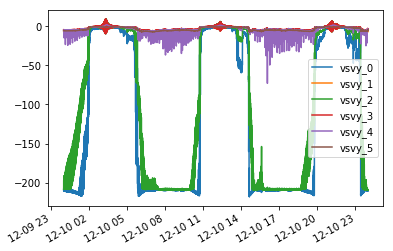

In [5]:
vsvy.iloc[::100].plot()

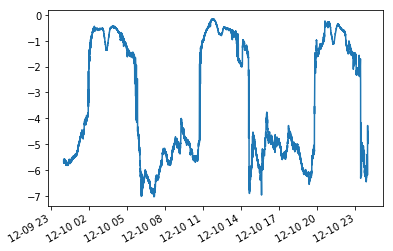

In [6]:
vsvy['vsvy_5'].iloc[::100].plot()

As this is the negative of the SC potential, we add these values to the ion energy and subtract from the electron energy.


In [7]:
SC_potential_add = vsvy['vsvy_5']

In [8]:
# #Calculate energy bins
# #  Although in most cases, adjacent energy steps are combined on board giving
# #   only 36 transmitted energies, keep the expansion to 72 to deal with cases
# #   where energies are not collapsed.
# #  Since the geometric factors and efficiencies are energy dependent, this
# #   will lead to some uncertainty in the calculated fluxes.
# #  Note that the same is also done for the angles.  In "normal" mode, adjacent
# #   spin angles are collapsed, giving 4-8-16-8-4 transmitted angles for pixels
# #   1-5.  However, for this data set we keep the expansion to 16 angles to
# #   allow for all possible cases.
# #==============================================================================
# # analyzer constant, voltages to energies
# #==============================================================================
# self.energy72 = self.inCounts['ESA_Volt'] * 7.035 # Volts  eV/V => eV   (K)

# #==============================================================================
# # low end and high end of bins, 15% dE/E
# #==============================================================================
# self.e72_minus = self.energy72 * 0.925 # eV*
# self.e72_plus = self.energy72 * 1.075
# self.delta_e = (self.e72_plus - self.e72_minus) / 1000.0 #[record, energy]  [keV]

# #these are stored [record, energy]
# #==============================================================================
# # energies to keV
# #==============================================================================
# self.e72_kev = self.energy72 / 1000.0  # [keV]
# # e72_kev_sq = e72_kev ** 2    # [keV**2]

def calcEnergy(voltage):
    return voltage * 7.035  # Volts  eV/V => eV 

# corrected for sc velocity (SPICE kernel - definitive attitude kernels)

In [9]:
# Print out the toolkit version
spice.tkvrsn("TOOLKIT")

'CSPICE_N0066'

In [10]:

masses = {'H':938.2720813e6, 'He':3728.401e6, 'O':14899.17e6}  # eV/c**2

def kms_to_c(kms):
    """
    change km/s into a fraction of c
    """
    return kms*1e3/constants.c

print(kms_to_c(3e8/1e3), kms_to_c(10/1e3))

def kms_to_e(kms, species='H'):
    """
    change km/s into energy for the species
    """
    return np.sign(kms)*0.5*masses[species]*kms_to_c(kms)**2
    
print(kms_to_e(10, 'H'), kms_to_e(10, 'He'), kms_to_e(10, 'O'))
print(kms_to_e(-10, 'H'), kms_to_e(-10, 'He'), kms_to_e(-10, 'O'))


def makeFullTimes_Ele(L1cdf, TagTimes):
    """
    go through and make the full time arrays
    """
    # raw read the Epoch!!  This is faster and in milliseconds so no conversion needed
    epoch16 = L1cdf.raw_var('Epoch_Elc_Cntr_e')[...]
    TagTimes['Epoch_Ele'] = dm.dmarray([pycdf.lib.epoch16_to_epoch(v) for v in epoch16])
    TagTimes['Epoch_Ele'].attrs = L1cdf['Epoch_Elc_Cntr_e'].attrs.copy()
    # (3879,)

    # if they are actually all the same no need to cycle through here
    if (L1cdf['FRAME_subtime'][:, 0, 0] != L1cdf['FRAME_subtime'][:, 0, 0][0]).any():
        raise(NotImplementedError("L1cdf['FRAME_subtime'] has different values, not sure what to do"))

    TagTimes['Epoch_Ele_FRAME_subtime'] = L1cdf['FRAME_subtime'][0, :, :].copy()
    # (16, 72)
    # L2cdf['FEDU'] CDF_REAL4 [3879, 5, 16, 72]
    ## multiply TagTimes['Epoch_Ele_FRAME_subtime'] by 1000 to make it a Epoch (milliseconds)
    TagTimes['Epoch_Ele_FRAME_subtime'] *= 1000

    ## make the full times as Epochs
    # Full times needs [epoch][sector][energy]  NO PIXEL!!
    # factor of 4 in time by not having it be [pixel] also (8 to 2 seconds)
    # also cdf is 140M smaller!!!
    TagTimes['Full_times_Ele'] = np.empty((L1cdf['Elc_Cntr_e'].shape[0],
                                           L1cdf['Elc_Cntr_e'].shape[2],
                                           L1cdf['Elc_Cntr_e'].shape[3]), dtype=np.float64)

    for ii, epoch in enumerate(TagTimes['Epoch_Ele']):
        TagTimes['Full_times_Ele'][ii] = epoch + TagTimes['Epoch_Ele_FRAME_subtime']


def makeFullTimes_Ion(L1cdf, TagTimes):
    """
    go through and make the full time arrays
    """
    # raw read the Epoch!!  This is faster and in milliseconds so no conversion needed
    epoch16 = L1cdf.raw_var('Epoch_Ion_Cntr_H')[...]
    # (3879,)
    TagTimes['Epoch_Ion'] = dm.dmarray([pycdf.lib.epoch16_to_epoch(v) for v in epoch16])
    TagTimes['Epoch_Ion'].attrs = L1cdf['Epoch_Ion_Cntr_H'].attrs.copy()

    # if they are actually all the same no need to cycle through here
    if (L1cdf['FRAME_subtime'][:, 0, 0] != L1cdf['FRAME_subtime'][:, 0, 0][0]).any():
        raise(NotImplementedError("L1cdf['FRAME_subtime'] has different values, not sure what to do"))

    TagTimes['Epoch_Ion_FRAME_subtime'] = L1cdf['FRAME_subtime'][0, :, :].copy()
    # (16, 72)
    # L2cdf['FEDU'] CDF_REAL4 [3879, 5, 16, 72]
    ## multiply TagTimes['Epoch_Ion_FRAME_subtime'] by 1000 to make it a Epoch (milliseconds)
    TagTimes['Epoch_Ion_FRAME_subtime'] *= 1000

    ## make the full times as Epochs
    # Full times needs [epoch][sector][energy]  NO PIXEL!!
    # factor of 4 in time by not having it be [pixel] also (8 to 2 seconds)
    # also cdf is 140M smaller!!!
    TagTimes['Full_times_Ion'] = np.empty((L1cdf['Ion_Cntr_H'].shape[0],
                                           L1cdf['Ion_Cntr_H'].shape[2],
                                           L1cdf['Ion_Cntr_H'].shape[3]), dtype=np.float64)

    for ii, epoch in enumerate(TagTimes['Epoch_Ion']):
        TagTimes['Full_times_Ion'][ii] = epoch + TagTimes['Epoch_Ion_FRAME_subtime']




1.0006922855944562 3.3356409519815205e-08
0.5219842419259951 2.0742027908201837 8.288781167826196
-0.5219842419259951 -2.0742027908201837 -8.288781167826196


In [11]:
spice.furnsh(['naif0012.tls', 'rbspa_2015_305_2018_058_01.deph.bsp', 
             'rbspa_2016_333_2016_363_01.dah.bc', 
             'rbspa_sclk_1982.tsc', 'rbspa_fk_2014_050.tf'])

In [12]:
# we are going to get positions between these two dates
utc = ['Dec 10, 2016', 'Dec 12, 2016']

# get et values one and two, we could vectorize str2et
etOne = spice.str2et(utc[0])
etTwo = spice.str2et(utc[1])
print("ET One: {}, ET Two: {}".format(etOne, etTwo))

ET One: 534600068.18331385, ET Two: 534772868.18336695


In [13]:
times = np.linspace(etOne, etTwo, 100)
#Run spkpos as a vectorized function
positions, lightTimes = spice.spkpos('RBSP_A', times, 'J2000', 'NONE', 'EARTH')

# Positions is a 3xN vector of XYZ positions
print("Positions: ")
print(positions[0])
positions = np.asarray(positions)
print(positions.shape)

# Light times is a N vector of time
print("Light Times: ")
print(lightTimes[0])

dt = np.asarray([spice.et2utc(v, 'ISOC', 5) for v in times])

pos = pd.DataFrame({'X':positions[:,0], 'Y':positions[:,1], 'Z':positions[:,2]}, 
                  index=pd.DatetimeIndex(dt))
pos.head()

Positions: 
[ 8165.69868539 34205.4947726   2504.13903303]
(100, 3)
Light Times: 
0.11760039632825865


,X,Y,Z
2016-12-10 00:00:00.000000,8165.698685,34205.494773,2504.139033
2016-12-10 00:29:05.454550,4502.772344,33153.109933,1837.489045
2016-12-10 00:58:10.909090,697.414587,31025.133239,1111.852138
2016-12-10 01:27:16.363640,-3129.218103,27629.546716,342.032162
2016-12-10 01:56:21.818180,-6760.485034,22655.849477,-444.448610


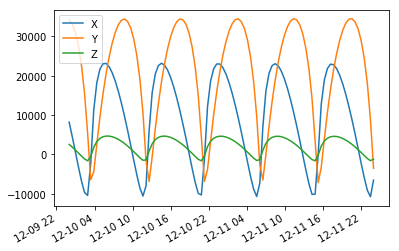

In [14]:
pos.plot()

In [15]:
def ET_to_ISO(et):
    """
    given spice ET return ISO representation
    """
    PICTUR = 'YYYY-MM-DDTHR:MN:SC.######'
    return spice.timout(et, PICTUR)

def get_var(fname, var):
    with pycdf.CDF(fname) as cdf:
        return cdf[var][...]

In [16]:
def cdfepoch_to_et(epoch, verbose=False):
    """
    Given a CDF epoch return the spice ET
    
    Given a l2 cdf filename open it and pull out the RAW ion and electron times
    NOTE: this just gets the data not the attrs
    """
    if verbose:
        print('Epoch[0], {0}'.format(epoch[0]))
        print('Epoch[-1], {0}'.format(epoch[-1]))
    if isinstance(epoch[0], datetime.datetime):
        if verbose:
            print("Input was datetime")
        TAI = spt.Ticktock(epoch, 'UTC').TAI
    else:
        if verbose:
            print("Input was CDF epoch")
        TT = spt.Ticktock(epoch, 'CDF')
        if verbose:
            print('TT[0], {0}'.format(TT[0].UTC))
            print('TT[-1], {0}'.format(TT[-1].UTC))
        TAI = TT.TAI
    TAI -= 1325419200 # there just seems to be an issue in SPICE TAI
    if verbose:
        print('TAI[0], {0}'.format(TAI[0]))
        print('TAI[-1], {0}'.format(TAI[-1]))
    # get the ET from the TAI
    ET = np.asarray([spice.unitim( v, 'TAI', 'ET' ) for v in TAI])
    if verbose:
        print('ET[0], {0}    {1}'.format(ET[0], ET_to_ISO(ET[0])))
        print('ET[-1], {0}    {1}'.format(ET[-1], ET_to_ISO(ET[-1])))
    if verbose:
        # perform a check
        st0 = spice.utc2et((TT[0].UTC)[0].isoformat())
        st1 = ET[0]
        print('from ISO: {0}   From ET: {1}    Diff: {2}'.format(st0, st1, st0-st1))
    return ET


In [17]:
def cdffile_to_et(fname):
    """
    Given a HOPE L1 or L2 CDF filename return the spice ET
    
    Given a l2 cdf filename open it and pull out the RAW ion and electron times
    NOTE: this just gets the data not the attrs
    """
    l1keys = ('Epoch_Ion_Cntr_H', 'Epoch_Elc_Cntr_e')
    l2keys = ('Epoch_Ion', 'Epoch_Ele')
    # get the CDF epoch from the file
    epochs = {}
    with pycdf.CDF(fname) as cdf:
        if l1keys[0] in cdf:
            keys = l1keys
            
#             raise(NotImplementedError("The L1 CDF epoch is 2 numbers"))
        else:
            keys = l2keys
        for k in keys:
            epochs[k] = cdf.raw_var(k)[...]
            if l1keys[0] in cdf:
                epochs[k] = np.asarray([pycdf.lib.epoch16_to_epoch(v) for v in epochs[k]])
    ETs = {}
    for k in epochs:
        ETs[k] = cdfepoch_to_et(epochs[k])
    return ETs


In [18]:
def get_pv(spicet, sat='RBSP_A'):
    """
    return the position, velocity, and light time for an array of spice ETs
    """
    positions = np.empty((len(spicet), 3), dtype=float)
    velocities = np.empty((len(spicet), 3), dtype=float)
    lightTimes = np.empty((len(spicet)), dtype=float)
    for ii, val in enumerate(tqdm.tqdm(spicet)):
        pv, lightTimes[ii] = spice.spkezr(sat, val, 'J2000', 'NONE', 'EARTH')
        positions[ii] = pv[:3]
        velocities[ii] = pv[3:]
    return positions, velocities, lightTimes


In [19]:

ETs = cdffile_to_et(l1name)
# DTs = get_var(l1name, 'Epoch_Ion')

pos_i, vel_i, _ = get_pv(ETs['Epoch_Ion_Cntr_H'])
pos_e, vel_e, _ = get_pv(ETs['Epoch_Elc_Cntr_e'])

100%|██████████| 4138/4138 [00:00<00:00, 39763.63it/s]


In [20]:
with pycdf.CDF(l1name) as cdf:
    Epoch_Ion_Cntr_H = cdf['Epoch_Ion_Cntr_H'][...]
    Epoch_Elc_Cntr_e = cdf['Epoch_Elc_Cntr_e'][...]

pv_i = pd.DataFrame({'X':pos_i[:,0], 'Y':pos_i[:,1], 'Z':pos_i[:,2], 
                     'VX':vel_i[:,0], 'VY':vel_i[:,1], 'VZ':vel_i[:,2],}, 
                     index=Epoch_Ion_Cntr_H)
pv_e = pd.DataFrame({'X':pos_e[:,0], 'Y':pos_e[:,1], 'Z':pos_e[:,2], 
                     'VX':vel_e[:,0], 'VY':vel_e[:,1], 'VZ':vel_e[:,2],}, 
                     index=Epoch_Elc_Cntr_e)

pv_i['V'] = np.sqrt(pv_i['VX'].values**2+pv_i['VY'].values**2+pv_i['VZ'].values**2)
pv_e['V'] = np.sqrt(pv_e['VX'].values**2+pv_e['VY'].values**2+pv_e['VZ'].values**2)

In [21]:
pv_i.head()

,VX,VY,VZ,X,Y,Z,V
2016-12-10 00:00:36.389386,-2.043643,-0.332244,-0.363795,8091.381516,34193.611049,2490.915938,2.102192
2016-12-10 00:00:59.086386,-2.045314,-0.339326,-0.364310,8044.977971,34185.989752,2482.653028,2.105036
2016-12-10 00:01:21.783387,-2.046978,-0.346418,-0.364825,7998.536573,34178.207597,2474.378435,2.107896
2016-12-10 00:01:44.479387,-2.048636,-0.353520,-0.365338,7952.059521,34170.264718,2466.092544,2.110771
2016-12-10 00:02:07.176388,-2.050286,-0.360631,-0.365851,7905.542899,34162.160195,2457.794649,2.113664


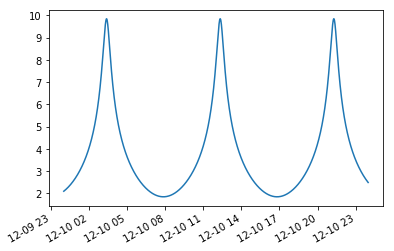

In [22]:
pv_i['V'].plot()

In [23]:
# need rotation matrix from RBSPA_SPACECRAFT to RBSPA_SCIENCE at each step
def get_RBSP_SCIENCE_vel(spicet, sat='RBSP_A'):
    # first get the rotations from RBSPA_SPACECRAFT to RBSPA_SCIENCE
    rotations = np.empty((len(spicet), 3, 3), dtype=float)
    for ii, val in enumerate(tqdm.tqdm(spicet)):
        rotations[ii] = spice.pxform('J2000', 
                                     '{0}_SCIENCE'.format(sat.replace('_', '')),
                                     val)
    # get the velocities in RBSPA_SPACECRAFT
    pos, vel, lt = get_pv(ETs['Epoch_Ion_Cntr_H'], sat=sat)
    # rotate the velocity into RBSPA_SCIENCE
    v_sci = np.zeros_like(vel)    
    v_sci = np.einsum('ij,ijk->ik',vel,rotations)
    return v_sci


v_sci = get_RBSP_SCIENCE_vel(ETs['Epoch_Ion_Cntr_H'])
v_sci[0], v_sci[100], v_sci.shape

100%|██████████| 3474/3474 [00:00<00:00, 38686.02it/s]


(array([-1.68370766,  0.99401607, -0.77218568]),
 array([-0.47538205,  0.43213007,  2.44104598]),
 (3474, 3))

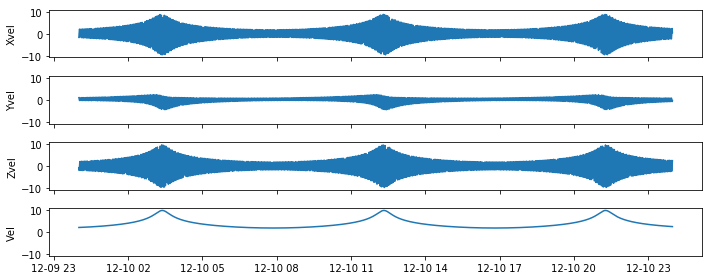

In [24]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=1, nrows=4, sharex=True, sharey=True, 
                                        figsize=(10,4))

ax1.plot(pv_i.index, v_sci[:,0])
ax1.set_ylabel('Xvel')
ax2.plot(pv_i.index, v_sci[:,1])
ax2.set_ylabel('Yvel')
ax3.plot(pv_i.index, v_sci[:,2])
ax3.set_ylabel('Zvel')
ax4.plot(pv_i.index, norm(v_sci, axis=1))
ax4.set_ylabel('Vel');
plt.tight_layout()

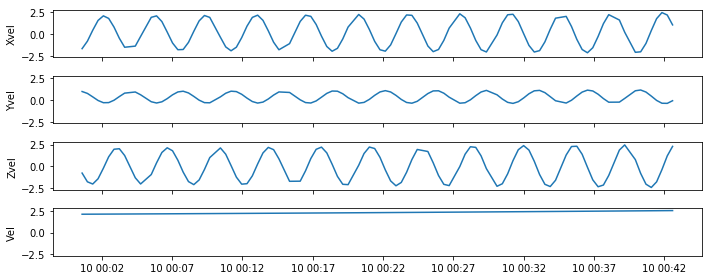

In [25]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=1, nrows=4, sharex=True, sharey=True, 
                                        figsize=(10,4))

ax1.plot(pv_i.index[0:100], v_sci[:,0][0:100])
ax1.set_ylabel('Xvel')
ax2.plot(pv_i.index[0:100], v_sci[:,1][0:100])
ax2.set_ylabel('Yvel')
ax3.plot(pv_i.index[0:100], v_sci[:,2][0:100])
ax3.set_ylabel('Zvel')
ax4.plot(pv_i.index[0:100], norm(v_sci, axis=1)[0:100])
ax4.set_ylabel('Vel');
plt.tight_layout()

In [26]:
# rotations from UVW to HOPE (UVW is RBSPA_SCIENCE in spice)
# These are taken from the HOPE Pitch angle code

# these have to be transposed because SPICE does rotation matrices
# indexed by [output dimension, input dimension]
# where lanlgeomag indexed by [input, output]

def get_HOPE_rotations():
    hope1_rot = np.matrix([[0.30432233, 0.17364818, 0.93660783],
                           [-0.05366024, 0.98480775, -0.16514923],
                           [-0.95105652, 0., 0.30901699]]).transpose()
    hope2_rot = np.matrix([[0.79672621, 0.17364818, 0.57885547],
                           [-0.14048433, 0.98480775, -0.10206784],
                           [-0.58778525, 0., 0.80901699]]).transpose()
    # 80 degree rotation around z
    hope3_rot = np.matrix([[0.98480775, 0.17364818, 0.],
                           [-0.17364818, 0.98480775, 0.],
                           [0., 0., 1.]]).transpose()
    hope4_rot = np.matrix([[0.79672621, 0.17364818, -0.57885547],
                           [-0.14048433, 0.98480775, 0.10206784],
                           [0.58778525, 0., 0.80901699]]).transpose()
    hope5_rot = np.matrix([[0.30432233, 0.17364818, -0.93660783],
                           [-0.05366024, 0.98480775, 0.16514923],
                           [0.95105652, 0., 0.30901699]]).transpose()

    rots = (hope1_rot, hope2_rot, hope3_rot, hope4_rot, hope5_rot)
    rotnp = np.asarray(rots)
    # we don't need below this but it is there, leave it for now
    # spin axis is omega
    # compute omega in uvw
    sc_uvw_rot = np.matrix([[0.81915204, -0.57357644, 0.],
                            [0.57357644, 0.81915204, 0.],
                            [-0., 0., 1.]])
    # omega is along Z in xyz and uvw!!  But leave this in for tuning
    omega_uvw = np.asarray((np.array([0, 0, 1]) * sc_uvw_rot))[0]
    return rots


In [27]:
def rotate_vsci_to_hope(v_sci):
    rots = get_HOPE_rotations()
    pixel_velocities = np.empty((len(v_sci), 3, 5), dtype=float)
    for pixel in tqdm.tqdm(range(5)):
        pixel_velocities[:,:,pixel] = np.asarray(v_sci*rots[pixel])
    return pixel_velocities
pix_v = rotate_vsci_to_hope(v_sci)
pix_v.shape

100%|██████████| 5/5 [00:00<00:00, 4230.69it/s]


(3474, 3, 5)

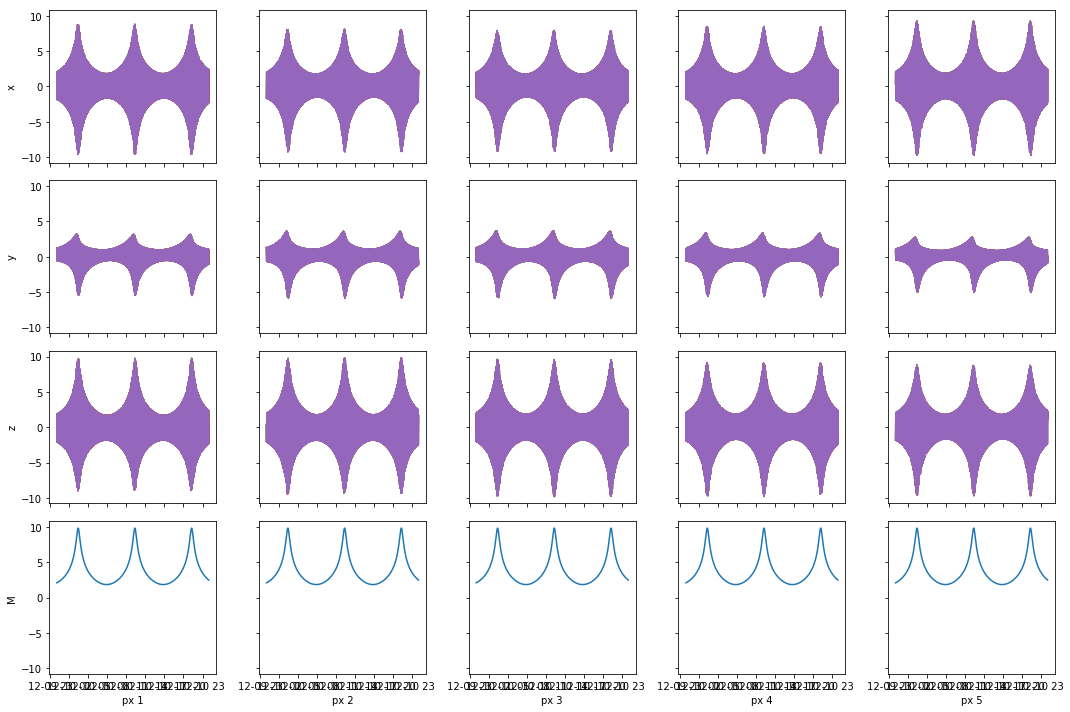

In [28]:
def plot_pixel_v_components(time, p_v):
    fig, ax = plt.subplots(ncols=5, nrows=4, sharex=True, sharey=True, figsize=(15,10))
    components = ('x', 'y', 'z', 'M')

    for comp in range(4):
        for pix in range(5):
            if comp < 3:
                ax[comp][pix].plot(time, p_v[:,comp,pix])
                ax[comp][pix].plot(time, p_v[:,comp,pix])
                ax[comp][pix].plot(time, p_v[:,comp,pix])
                ax[comp][pix].plot(time, p_v[:,comp,pix])
                ax[comp][pix].plot(time, p_v[:,comp,pix])
            else:
                ax[comp][pix].plot(time, norm(p_v[:,:,pix], axis=1))
            ax[-1][pix].set_xlabel('px {0}'.format(pix+1))
        ax[comp][0].set_ylabel('{0}'.format(components[comp]))
    return fig, ax
    
fig, ax = plot_pixel_v_components(pv_i.index, pix_v)
plt.tight_layout()

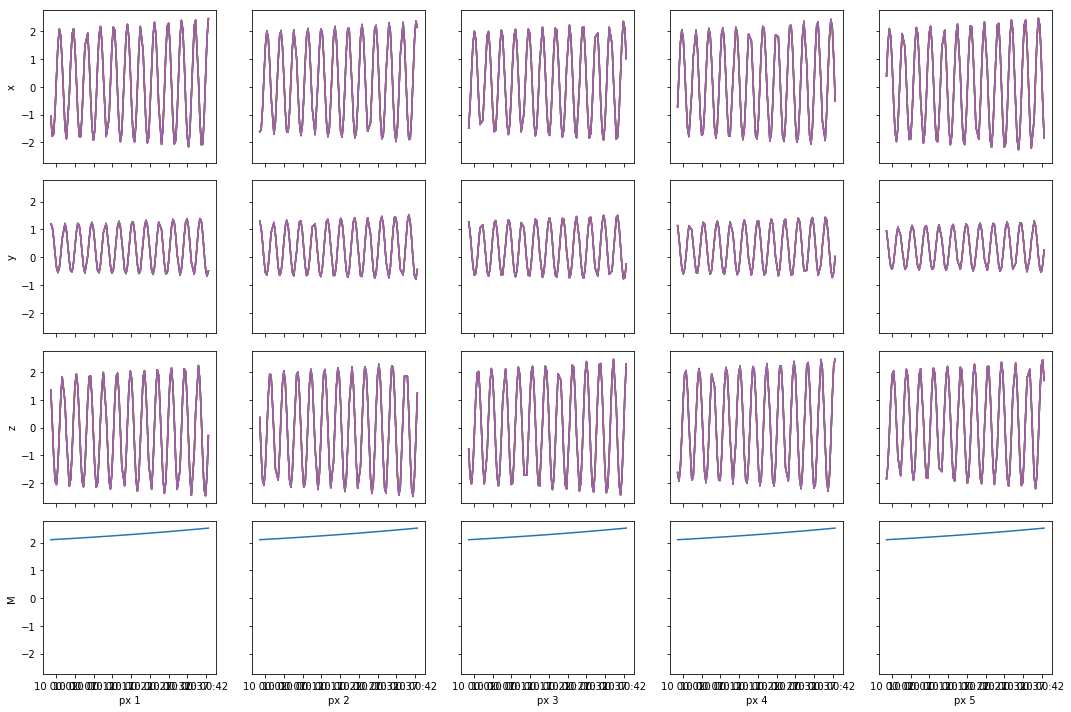

In [29]:
fig, ax = plot_pixel_v_components(pv_i.index[0:100], pix_v[0:100])
plt.tight_layout()

### Apply velocity correction to the energy by species
$E=\frac{1}{2}mv^2$

$v=\sqrt{\frac{2E}{m}}$

The unit vectors for each telescope is $[1,0,0]$ pointed out of the telescope. In the pitch angle code there is a -1 because particles go into telescopes. We will have to work to validate this here to make sure we have the right sign and not off by 180. 

In [30]:
# convert the v_Sci into an energy correction

v_sci = get_RBSP_SCIENCE_vel(ETs['Epoch_Ion_Cntr_H'])
p_v = rotate_vsci_to_hope(v_sci)
e_corr = kms_to_e(p_v)
print(v_sci.shape, p_v.shape, e_corr.shape)
# then we only need the x-component of the E correction as that is into the aperature
e_corr = {'H':kms_to_e(p_v, species='H')[:, 0, :], 
         'He':kms_to_e(p_v, species='He')[:, 0, :], 
         'O':kms_to_e(p_v, species='O')[:, 0, :]}
print(v_sci.shape, p_v.shape, e_corr['H'].shape)
tb.dictree(e_corr, verbose=True)
# e_corr = pd.DataFrame(e_corr, index=dt)
# e_corr.head()

100%|██████████| 5/5 [00:00<00:00, 2189.32it/s]

(3474, 3) (3474, 3, 5) (3474, 3, 5)
(3474, 3) (3474, 3, 5) (3474, 5)
+
|____H (numpy.ndarray (3474, 5))
|____He (numpy.ndarray (3474, 5))
|____O (numpy.ndarray (3474, 5))


In [31]:
e_corr['H'].shape

(3474, 5)

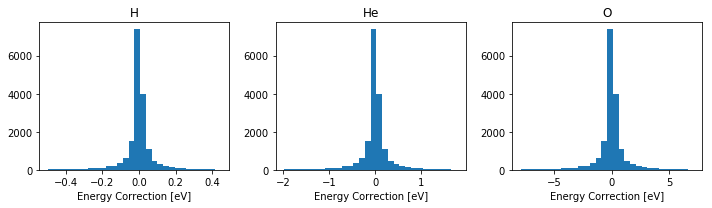

In [32]:
fig, ax = plt.subplots(ncols=3, figsize=(10,3))

ax[0].hist(e_corr['H'].flatten(), 30);
ax[0].set_xlabel('Energy Correction [eV]')
ax[0].set_title('H')

ax[1].hist(e_corr['He'].flatten(), 30);
ax[1].set_xlabel('Energy Correction [eV]')
ax[1].set_title('He')

ax[2].hist(e_corr['O'].flatten(), 30);
ax[2].set_xlabel('Energy Correction [eV]')
ax[2].set_title('O');
plt.tight_layout()

In [34]:
df = pd.DataFrame({'H1':e_corr['H'][:,0], 
                  'H2':e_corr['H'][:,1], 
                  'H3':e_corr['H'][:,2], 
                  'H4':e_corr['H'][:,3], 
                  'H5':e_corr['H'][:,4]}, 
                 index=pd.DatetimeIndex(Epoch_Ion_Cntr_H))
df.head()

,H1,H2,H3,H4,H5
2016-12-10 00:00:36.389386,-0.005898,-0.013629,-0.011519,-0.002720,0.000768
2016-12-10 00:00:59.086386,-0.016504,-0.012516,-0.002384,0.001339,0.012489
2016-12-10 00:01:21.783387,-0.015131,-0.003049,0.001259,0.013095,0.022949
2016-12-10 00:01:44.479387,-0.003921,0.000876,0.012175,0.022133,0.016954
2016-12-10 00:02:07.176388,0.000767,0.011516,0.020895,0.015672,0.003206


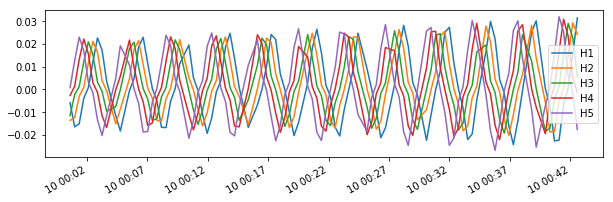

In [37]:
df.iloc[0:100].plot(figsize=(10,3))

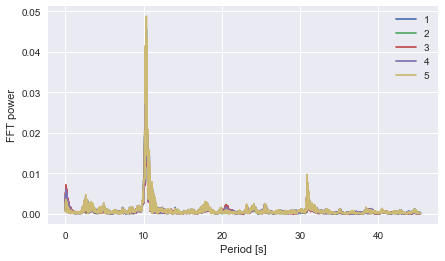

In [61]:
plt.figure(figsize=(7,4))
import scipy.fftpack
yf1 = scipy.fftpack.fft(df['H1'].values)
yf2 = scipy.fftpack.fft(df['H2'].values)
yf3 = scipy.fftpack.fft(df['H3'].values)
yf4 = scipy.fftpack.fft(df['H4'].values)
yf5 = scipy.fftpack.fft(df['H5'].values)
xf = np.linspace(0.0, (2.0*22697000000/1e9), len(df)//2)
plt.plot(xf, 2.0/len(df) * np.abs(yf1[0:len(df)//2]), label='1')
plt.plot(xf, 2.0/len(df) * np.abs(yf2[0:len(df)//2]), label='2')
plt.plot(xf, 2.0/len(df) * np.abs(yf3[0:len(df)//2]), label='3')
plt.plot(xf, 2.0/len(df) * np.abs(yf4[0:len(df)//2]), label='4')
plt.plot(xf, 2.0/len(df) * np.abs(yf5[0:len(df)//2]), label='5')
plt.xlabel('Period [s]')
plt.legend()
plt.ylabel('FFT power');
# plt.xlim((40,100))
# plt.ylim((0,0.02))

# Background subtraction
This remains a TODO

# Pitch angle tag each measurement (EMFISIS magnetometer data)
This is already done and still remains valid

# time average the data to 1 minute
Collect all data for each minute for each pixel (pixel, energy, counts)
# interpolate the 1m counts to a fixed grid of energies between HOPE-low and HOPE-hi (72 or 36?)
Different for ions and electrons
No extrapolation beyond measurements, up or down
save original counts for use in statisitcal uncertainity
